## IMPORTS

In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from glob import glob
import matplotlib.pyplot as plt
import cv2

## PATHS AND IMAGE SIZE

In [2]:
TRAIN_PATH = r'C:\PROJECTS\ai_ml\Memowee\MEMOWEE_DATASET\train'
VAL_PATH   = r'C:\PROJECTS\ai_ml\Memowee\MEMOWEE_DATASET\val'
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 30

## LOADING THE DATASET

In [3]:
def get_image_paths_and_labels(path):
    image_paths = []
    labels = []
    class_folders = sorted(os.listdir(path))
    class_map = {}
    for idx, cls in enumerate(class_folders):
        cls_path = os.path.join(path, cls)
        if os.path.isdir(cls_path):
            class_map[idx] = cls
            for img_file in glob(os.path.join(cls_path, '*.jpg')):
                image_paths.append(img_file)
                labels.append(idx)
    return image_paths, labels, class_map

train_paths, train_labels, train_classes = get_image_paths_and_labels(TRAIN_PATH)
val_paths, val_labels, val_classes = get_image_paths_and_labels(VAL_PATH)

print(f"Train samples: {len(train_paths)}, Validation samples: {len(val_paths)}")

Train samples: 18400, Validation samples: 2400


## SIAMESE PAIR GENERATION

In [4]:
class SiameseDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, labels, batch_size=32, img_size=(128,128), shuffle=True):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.class_indices = self._map_class_indices()
        self.on_epoch_end()
    
    def _map_class_indices(self):
        class_indices = {}
        for idx, label in enumerate(self.labels):
            class_indices.setdefault(label, []).append(idx)
        return class_indices
    
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))
    
    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)
    
    def __getitem__(self, index):
        batch_indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        x1_batch, x2_batch, y_batch = [], [], []
        
        for idx in batch_indices:
            x1 = self._load_image(self.image_paths[idx])
            label = self.labels[idx]

            # Positive pair
            pos_idx = idx
            while pos_idx == idx:
                pos_idx = random.choice(self.class_indices[label])
            x2 = self._load_image(self.image_paths[pos_idx])
            x1_batch.append(x1)
            x2_batch.append(x2)
            y_batch.append(1.0)

            # Negative pair
            neg_label = label
            while neg_label == label:
                neg_label = random.choice(list(self.class_indices.keys()))
            x2 = self._load_image(self.image_paths[random.choice(self.class_indices[neg_label])])
            x1_batch.append(x1)
            x2_batch.append(x2)
            y_batch.append(0.0)

        # Convert to NumPy arrays
        x1_batch = np.array(x1_batch, dtype=np.float32)
        x2_batch = np.array(x2_batch, dtype=np.float32)
        y_batch = np.array(y_batch, dtype=np.float32).reshape(-1, 1)  # shape (batch*2, 1)

        return (x1_batch, x2_batch), y_batch
    
    def _load_image(self, path):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self.img_size)
        img = img / 255.0
        return img

# generators
train_gen = SiameseDataGenerator(train_paths, train_labels, batch_size=BATCH_SIZE, img_size=IMG_SIZE)
val_gen = SiameseDataGenerator(val_paths, val_labels, batch_size=BATCH_SIZE, img_size=IMG_SIZE)

## EMBEDDING MODEL and CUSTOM NORMALIZATION LAYER

In [5]:
class L2Normalization(layers.Layer):
    def call(self, inputs):
        return tf.math.l2_normalize(inputs, axis=1)

def embedding_model(input_shape=IMG_SIZE + (3,)):
    inp = layers.Input(shape=input_shape)

    x = layers.RandomFlip("horizontal")(inp)
    x = layers.RandomRotation(0.1)(x)
    x = layers.RandomZoom(0.1)(x)

    x = layers.Conv2D(32, 3, padding="same", activation="relu",
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(64, 3, padding="same", activation="relu",
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(128, 3, padding="same", activation="relu",
                      kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu",
                     kernel_regularizer=regularizers.l2(1e-4))(x)
    x = L2Normalization()(x)

    return models.Model(inp, x)

# Embedding model
embedding_net = embedding_model()
embedding_net.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 128, 128, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ l2_normalization                │ (None, 128)            │             0 │
│ (L2Normalization)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,287,680 (16.36 MB)

 Trainable params: 4,287,680 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

## DISTANCE AND CONTRASTIVE LOSS

In [6]:
def euclidean_distance(vects, eps=1e-9):
    x, y = vects
    sq = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
    return tf.sqrt(tf.maximum(sq, eps))


def contrastive_loss(y_true, y_pred, margin=1.0):
    y_true = tf.cast(y_true, y_pred.dtype)
    if len(y_true.shape) == 1:  
        y_true = tf.expand_dims(y_true, axis=1)

    square_pred = tf.square(y_pred)
    margin_sq = tf.square(tf.maximum(margin - y_pred, 0.0))

    return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_sq)

def contrastive_accuracy_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    if len(y_true.shape) == 1:
        y_true = tf.expand_dims(y_true, axis=1)
    y_pred_binary = tf.cast(y_pred < 0.7, tf.float32)  # threshold 0.7
    return tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred_binary), tf.float32))

## SIAMESE NETWORK

In [7]:
input_a = layers.Input(shape=IMG_SIZE + (3,))
input_b = layers.Input(shape=IMG_SIZE + (3,))
emb_a = embedding_net(input_a)
emb_b = embedding_net(input_b)
distance = layers.Lambda(euclidean_distance)([emb_a, emb_b])
siamese = models.Model([input_a, input_b], distance)
siamese.compile(loss=contrastive_loss, optimizer=Adam(0.001), metrics=[contrastive_accuracy_metric])
siamese.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 128)       │  4,287,680 │ input_layer_1[0]… │
│ (Functional)        │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ functional[0][0], │
│                     │                   │            │ functional[1][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,287,680 (16.36 MB)

 Trainable params: 4,287,680 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

## LEARNING RATE SCHEDULER

In [8]:
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1
)

In [9]:
# save training configuration (PDF requirement)
training_config = {
    "optimizer": "Adam(learning_rate=0.001)",
    "epochs": 30,
    "image_size": IMG_SIZE,
    "batch_size": 32,
    "loss": "Contrastive Loss"
}

print("\n=== TRAINING CONFIGURATION ===")
print(training_config)


=== TRAINING CONFIGURATION ===
{'optimizer': 'Adam(learning_rate=0.001)', 'epochs': 30, 'image_size': (128, 128), 'batch_size': 32, 'loss': 'Contrastive Loss'}


## MODEL TRAINING

In [10]:
history = siamese.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[lr_schedule],
    verbose=1
)

c:\Users\Axel John Nuqui\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
575/575 ━━━━━━━━━━━━━━━━━━━━ 604s 1s/step - contrastive_accuracy_metric: 0.5440 - loss: 0.2696 - val_contrastive_accuracy_metric: 0.5819 - val_loss: 0.2394 - learning_rate: 0.0010
Epoch 2/30
575/575 ━━━━━━━━━━━━━━━━━━━━ 602s 1s/step - contrastive_accuracy_metric: 0.5811 - loss: 0.2406 - val_contrastive_accuracy_metric: 0.6110 - val_loss: 0.2282 - learning_rate: 0.0010
Epoch 3/30
575/575 ━━━━━━━━━━━━━━━━━━━━ 604s 1s/step - contrastive_accuracy_metric: 0.5953 - loss: 0.2327 - val_contrastive_accuracy_metric: 0.6027 - val_loss: 0.2244 - learning_rate: 0.0010
Epoch 4/30
575/575 ━━━━━━━━━━━━━━━━━━━━ 600s 1s/step - contrastive_accuracy_metric: 0.6022 - loss: 0.2303 - val_contrastive_accuracy_metric: 0.6285 - val_loss: 0.2217 - learning_rate: 0.0010
Epoch 5/30
575/575 ━━━━━━━━━━━━━━━━━━━━ 571s 993ms/step - contrastive_accuracy_metric: 0.6098 - loss: 0.2268 - val_contrastive_accuracy_metric: 0.6510 - val_loss: 0.2139 - learning_rate: 0.0010
Epoch 6/30
575/575 ━━━━━━━━━━━━━━━━━━━━ 50

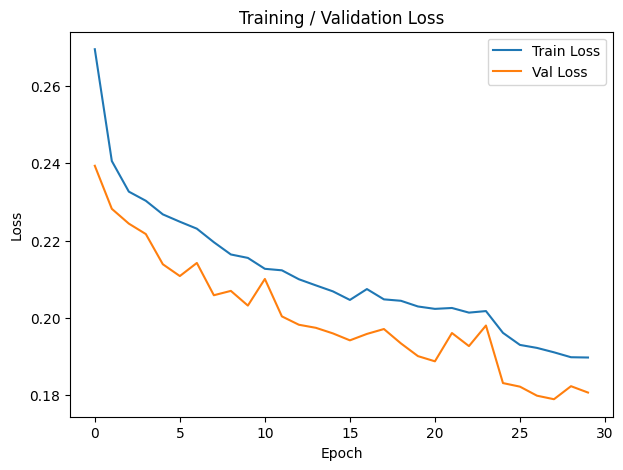

In [11]:
plt.figure(figsize=(7,5))
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.title("Training / Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## SAVE MODEL

In [13]:
embedding_net.save("MEMOWEE_EMBEDDING_MODEL.h5")
print("Embedding model saved.")

Embedding model saved.
